In [1]:
%matplotlib inline

In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

In [6]:
kicid = 5705575
times, dmag = np.loadtxt(f"../../data/kic{kicid}_lc.txt",usecols=(0,1)).T
mags = dmag * 1000. 

metadata = np.loadtxt(f"../../data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

Let's suppose that we don't want to use the default priors on our orbit model. Defining your own priors is rather straightforward in `maelstrom`. We first import the `PB1Model` class for our star, and pass in the relevant data.

In [12]:
from maelstrom import PB1Model
pb1 = PB1Model(times, mags, freq=nu_arr)

Now, the `pb1` parameter is itself a PyMC3 Model which can be used on the context stack. If we want to use the default priors here we'd call `pb1.init_params()`. But if we don't, we can define them ourselves. Let's try changing $\varpi$ to a uniform prior between 0 and 2$\pi$

In [13]:
with pb1:
    logperiod = pm.Normal("logperiod", mu=np.log(100), sd=100)
    period = pm.Deterministic("period", tt.exp(logperiod))
    t0 = pm.Normal("t0", mu=0.0, sd=100.0)
    eccen = pm.Uniform("eccen", lower=1e-5, upper=1.0 - 1e-5, testval=0.5)
    logs = pm.Normal('logs', mu=np.log(np.std(pb1.flux)), sd=100)
    lighttime_a = pm.Normal('lighttime_a', mu=0.0, sd=100.0)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    
    # Our changed value
    varpi = pm.Uniform("varpi", lower=0, upper=2*np.pi, testval=np.pi)

The tricky thing about this is that the model names (those are the strings, i.e. lighttime_a) must be the same as those defined by default. The variable names can change, but the model names can't.

In [14]:
pb1

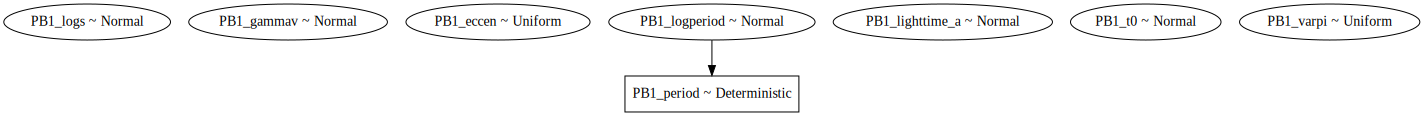

In [15]:
pb1.print_model()

The parameters have been assigned, but they're not linked to anything. To fix that, we call `init_orbit()`.

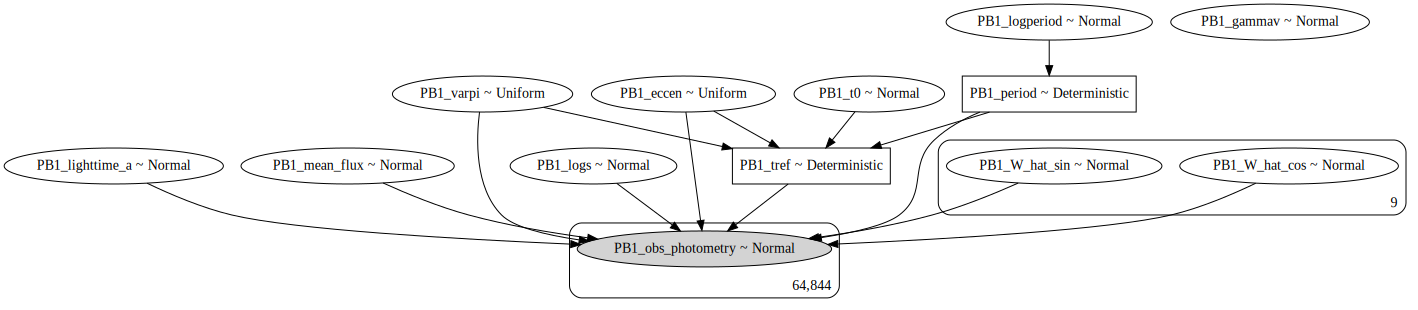

In [17]:
pb1.init_orbit()
pb1.print_model()